# Multivariate Time Series Forecasting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will first load in the extracted features dataset created from our data processing notebook. This dataset contains all extracted features from the original raw windowed data, giving us over 200 unique new features.

In [ ]:
# load the dataset
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import read_csv
# load data
X = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/extracted_features.csv')
Y = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/extracted_features_labels.csv')
# summarize shape
print(X.shape)
print(Y.shape)
# show first few rows
print(X.head())
print(Y.head())

(26417, 271)
(26417, 3)
   Unnamed: 0  ...  value__permutation_entropy__dimension_4__tau_1
0       46343  ...                                            -0.0
1       46343  ...                                            -0.0
2       46343  ...                                            -0.0
3       46343  ...                                            -0.0
4       46343  ...                                            -0.0

[5 rows x 271 columns]
      id  time  1
0  46343   390  0
1  46343   420  0
2  46343   450  0
3  46343   480  0
4  46343   510  0


Combine the datasets, relabel columns as required, and sort the new dataframe by time and id; this gives us each subjects sleep cycle, one after another.

In [ ]:
# SORT AND RE LABEL DF 

df = pd.concat([Y, X[X.columns[2:]]], axis=1)
df = df.rename(columns={"1": "y"})
df = df.sort_values(["id", "time"])
df = df.reset_index(drop=True)
# df["Last Period Label"] = df.groupby(["id"])["y"].shift()
df = df.dropna()
df

,id,time,y,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,value__mean,value__length,value__standard_deviation,value__variation_coefficient,value__variance,value__skewness,value__kurtosis,value__absolute_sum_of_changes,value__longest_strike_below_mean,value__longest_strike_above_mean,value__count_above_mean,value__count_below_mean,value__last_location_of_maximum,value__first_location_of_maximum,value__last_location_of_minimum,value__first_location_of_minimum,value__percentage_of_reoccurring_values_to_all_values,value__percentage_of_reoccurring_datapoints_to_all_datapoints,value__sum_of_reoccurring_values,value__sum_of_reoccurring_data_points,value__ratio_value_number_to_time_series_length,value__maximum,value__minimum,value__benford_correlation,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,...,"value__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","value__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","value__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",value__number_crossing_m__m_0,value__number_crossing_m__m_-1,value__number_crossing_m__m_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_2,value__energy_ratio_by_chunks__num_segments_10__segment_focus_3,value__energy_ratio_by_chunks__num_segments_10__segment_focus_4,value__energy_ratio_by_chunks__num_segments_10__segment_focus_5,value__energy_ratio_by_chunks__num_segments_10__segment_focus_6,value__energy_ratio_by_chunks__num_segments_10__segment_focus_7,value__energy_ratio_by_chunks__num_segments_10__segment_focus_8,value__energy_ratio_by_chunks__num_segments_10__segment_focus_9,value__ratio_beyond_r_sigma__r_0.5,value__ratio_beyond_r_sigma__r_1,value__ratio_beyond_r_sigma__r_1.5,value__ratio_beyond_r_sigma__r_2,value__ratio_beyond_r_sigma__r_2.5,value__ratio_beyond_r_sigma__r_3,value__ratio_beyond_r_sigma__r_5,value__ratio_beyond_r_sigma__r_6,value__ratio_beyond_r_sigma__r_7,value__ratio_beyond_r_sigma__r_10,value__count_above__t_0,value__count_below__t_0,value__lempel_ziv_complexity__bins_2,value__lempel_ziv_complexity__bins_3,value__lempel_ziv_complexity__bins_5,value__lempel_ziv_complexity__bins_10,value__lempel_ziv_complexity__bins_100,value__fourier_entropy__bins_2,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1
0,46343,390,0,1.0,0.0,0.0,0.0,89.910614,8100.838344,30.793696,30.186508,22.242584,0.235069,22.477653,4.0,38.986724,1.734466,1519.964679,1.999177,3.997235,92.381088,3.0,1.0,1.0,3.0,1.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,1.0,90.0,-0.559524,-0.220047,-892.340880,0.0,0.0,...,-0.286355,0.927415,0.0,3.0,0.0,1.0,0.000039,5.885008e-05,0.000006,0.999897,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.50,0.75,0.75,0.75,0.75,1.00,0.636514,1.098612,1.098612,1.098612,1.098612,0.693147,-0.0
1,46343,420,0,1.0,0.0,0.0,0.0,100.727615,10201.949516,34.534958,33.877009,25.002583,0.179321,25.181904,4.0,43.776239,1.738401,1916.359096,1.999278,3.997573,103.604874,3.0,1.0,1.0,3.0,1.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,1.0,101.0,-0.631027,0.240954,-1602.303277,0.0,0.0,...,-0.318167,0.922892,0.0,3.0,0.0,1.0,0.000039,4.436769e-05,0.000010,0.999907,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.50,0.75,0.75,0.75,0.75,1.00,0.636514,1.098612,1.098612,1.098612,1.098612,0.693147,-0.0
2,46343,450,0,1.0,0.0,0.0,0.0,93.513177,8465.342833,30.757888,30.705180,22.563936,0.814358,23.378294,4.0,39.620589,1.694760,1569.

## Helper Functions

#### Plotting function

In [ ]:
import matplotlib.pyplot as plt

def plot_predict(train, val, pred):

    val["prediction"] = pred

    f, ax = plt.subplots(figsize=(28, 8))

    recent = train[int(len(train)*0.95):]

    ax.plot(recent.time, recent.y, 'ko', markersize=3, label="train")

    ax.plot(val.time, round(val.prediction), 'ro', markersize=3, label="forecast")

    ax.grid(ls=':', lw=0.5)
    plt.xlabel("Time elapsed (sec)")
    plt.ylabel("Sleep Stage")
    plt.legend()

#### Root Mean Squared Log Error

We will use root mean squared log error to assess the performance of our forecasting techniques. 

It is the commonly used root mean squared error (RMSE) applied to the log of our target and prediction. The metric allows us to approximate the % error between our forcasting model and the ground truth, making it easier to interpret than other measures.

In [ ]:
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

#### Other regression metrics

We will also use several other metrics to evaluate and compare models; these are included in the below function.

In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

In [ ]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):
  
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)

    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 

    mse=metrics.mean_squared_error(y_true, y_pred) 

    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)

    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)

    r2=metrics.r2_score(y_true, y_pred)

    rmsle = np.sqrt(metrics.mean_squared_log_error(y_true, y_pred))
    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('root_mean_squared_log_error: ', round(rmsle,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## Setting a Baseline

Before creating an actual forecasting model, we chose to create a baseline prediction performance. We accomplished this by splitting our data into training and testing sets, and predicting the labels of future rows based on the last label in the training data. 

While this is a very simple approach to the problem, it provides a good understanding of the prediction difficulty and enables us to decide if our models are performing reasonably well.

In [ ]:
# this baseline will start at the 80th percentile of our data
# it will guess that the remaining future sleep stages are all the same as
# the last sleep stage it has seen

mean_error = []
print(len(df))
for t in range(int(len(df)*0.8), len(df), 500):
    timestep = df.iloc[t]["time"]

    train = df.loc[df["time"] < timestep]
    val = df.loc[df["time"] >= timestep]

    p = np.full(shape=len(val), fill_value=train.iloc[-1].y, dtype=np.int)

    error = rmsle(val['y'].values, p)
    print('Time {}sec - Error {}'.format(timestep, error))
    mean_error.append(error)
print('Mean Error = {}'.format(np.mean(mean_error)))


26417
Time 3390.0sec - Error 1.2899140773451414
Time 18420.0sec - Error 0.5168000521536505
Time 4950.0sec - Error 0.4729450060683742
Time 19950.0sec - Error 0.5203295692068503
Time 6720.0sec - Error 0.7506160596381407
Time 21720.0sec - Error 1.335425180551181
Time 8190.0sec - Error 0.7516604219224446
Time 23190.0sec - Error 1.317578758339361
Time 11430.0sec - Error 0.49813860717971764
Time 26430.0sec - Error 1.2996750110580322
Time 13080.0sec - Error 0.5012522590700376
Mean Error = 0.8413031820484483


This error rate is quite high, which indicates that machine learning models could provide some improvement.

We can see that simply guessing the future sleep stage based on whatever the last sleep stage was gives us a poor performance most of the time, as sleep stages rarely stay the same. This is not a good method of prediction and we can see heavy error scores when the stage changes and the baseline has no way of knowing.

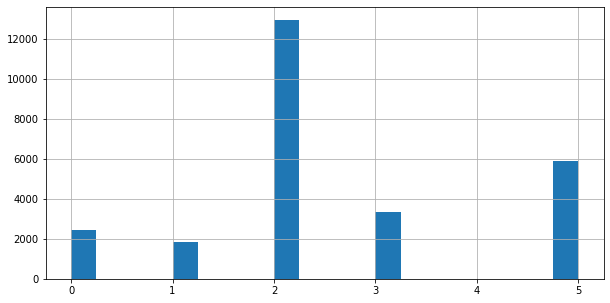

In [ ]:
# a large proportion of our data is in NREM 2 stage,
# so even guessing label 2 will get you a "good" accuracy score
df['y'].hist(bins=20, figsize=(10,5))

## Random Forest Regressor

The first model we will create is the Random Forest Regressor. Similar to the Random Forest Classifier, it is relatively easy to understand, does not require many parameters to get started, and usually performs well on most tasks.

We will make use of the model here by providing training data up to the 80th percentile, and asking what the next row of sleep data for all subjects will look like.

In [ ]:
# this cell builds a random forest regressor from the first 80%
# of rows from our data
# it then attempts to predict the next row and calcualtes the rmsle
timestep = df.iloc[int(len(df)*0.8)]["time"]

train = df.loc[df["time"] < timestep]
val = df.loc[df["time"] == timestep]

xtr, xts = train.drop(['y'], axis=1), val.drop(['y'], axis=1)
ytr, yts = train['y'].values, val['y'].values

mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
mdl.fit(xtr, ytr)

p = mdl.predict(xts)

error = rmsle(yts, p)
print('Time {}sec - Error {}'.format(timestep, error))

Time 3390.0sec - Error 0.22457268660805593


The error rate is much better here than our baseline.

However, in our use case, predicting what the next 30sec of sleep looks like is not very helpful, and should not be too difficult to do. 

Instead, we want to predict what the next 20 minutes will look like.

In [ ]:
minutes_ahead = 20
predict_window = int((minutes_ahead*60))

nxts = df.loc[(df['time'] >= timestep) & (df['time'] <= timestep+predict_window)].drop(["y"], axis=1)

nyts = df.loc[(df['time'] >= timestep) & (df['time'] <= timestep+predict_window)]["y"].values

pred = mdl.predict(nxts)

error = rmsle(nyts, pred)
print("{} minute prediction error: {}".format(minutes_ahead, error))
print("test length: {}".format(len(nxts)))

20 minute prediction error: 0.3559460066577148
test length: 1232


This prediction window includes many rows, so it is good to see only ~10% drop off in performance, still significantly better than our baseline. 

Below, we can see where the model takes over and attempts to predict the next 20 minutes of sleep in the dataset.

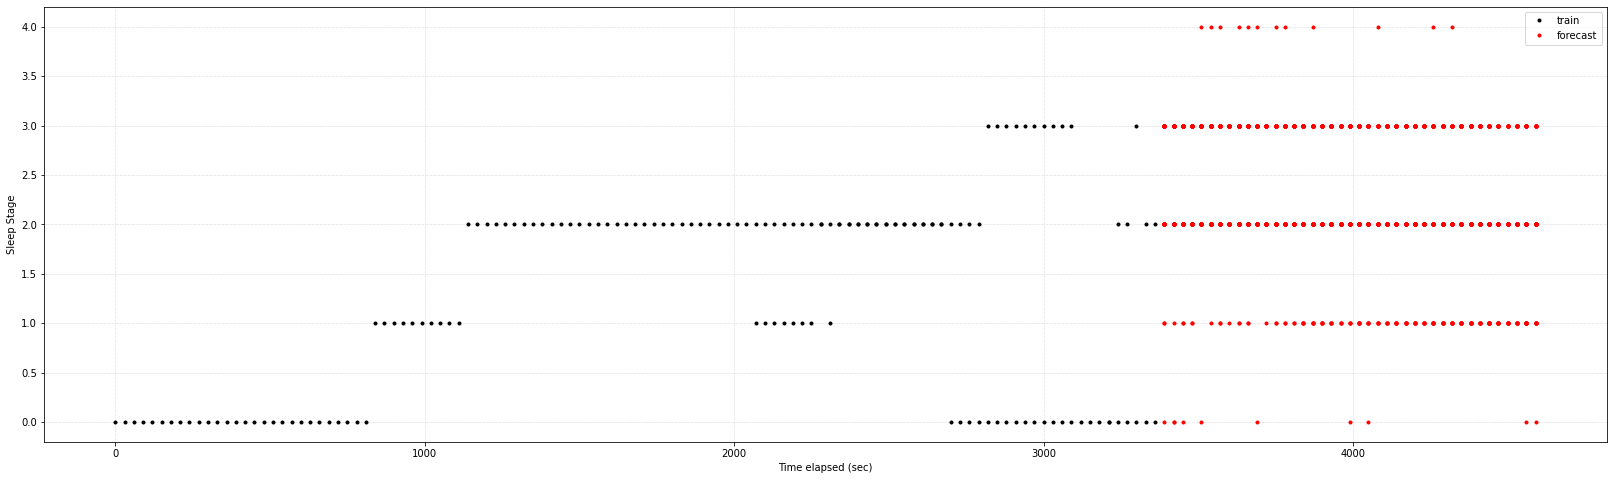

In [ ]:
plot_predict(train, nxts, pred)

## Changing the Loss Function (and Target Distribution)

We are evaluating our results using the log of our predictions and target, but we are training using them in their original form, so we are optimizing the model using the MSE instead of the MSLE.

Often we can get an improvement by using the same function to evaluate and optimize your model. Here, we can do this by simply taking the log of our target variable before passing it to be fitted.

By taking the log of the target we get the additional benefit that its distribution will look more like a normal distribution. This usually helps the model learn better.

In [ ]:
# this function allows us to iteratively train our model
# in steps of 1500 index, predicting "x" mins ahead

def rf_forecast(df, minutes_ahead=20, step_rate=1500):
    mean_error = []
    predict_window = minutes_ahead*60

    print("Creating {} models for {} minute prediction windows".format(
        int(round(len(df)*0.2/step_rate)), minutes_ahead
    ))

    for t in range(int(len(df)*0.8), len(df)-minutes_ahead*2, step_rate):
        timestep = df.iloc[t]["time"]

        train = df.loc[df["time"] < timestep].copy()
        val = df.loc[(df['time'] >= timestep) & (df['time'] <= timestep+predict_window)].copy()

        xtr, xts = train.drop(['y'], axis=1), val.drop(['y'], axis=1)
        ytr, yts = train['y'].values, val['y'].values

        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        # mdl = LGBMRegressor(n_estimators=100, learning_rate=0.01)

        mdl.fit(xtr, np.log1p(ytr))

        p = np.expm1(mdl.predict(xts))

        error = rmsle(yts, p)
        print("{} minute prediction error: {}".format(minutes_ahead, error))
        mean_error.append(error)

        plot_predict(train, val, p)

    print('Mean Error = %.5f' % np.mean(mean_error))

Creating 4 models for 20 minute prediction windows
20 minute prediction error: 0.39254765559776456
20 minute prediction error: 0.4974164817913185
20 minute prediction error: 0.41325069084540883
20 minute prediction error: 0.5847791828516147
Mean Error = 0.47200


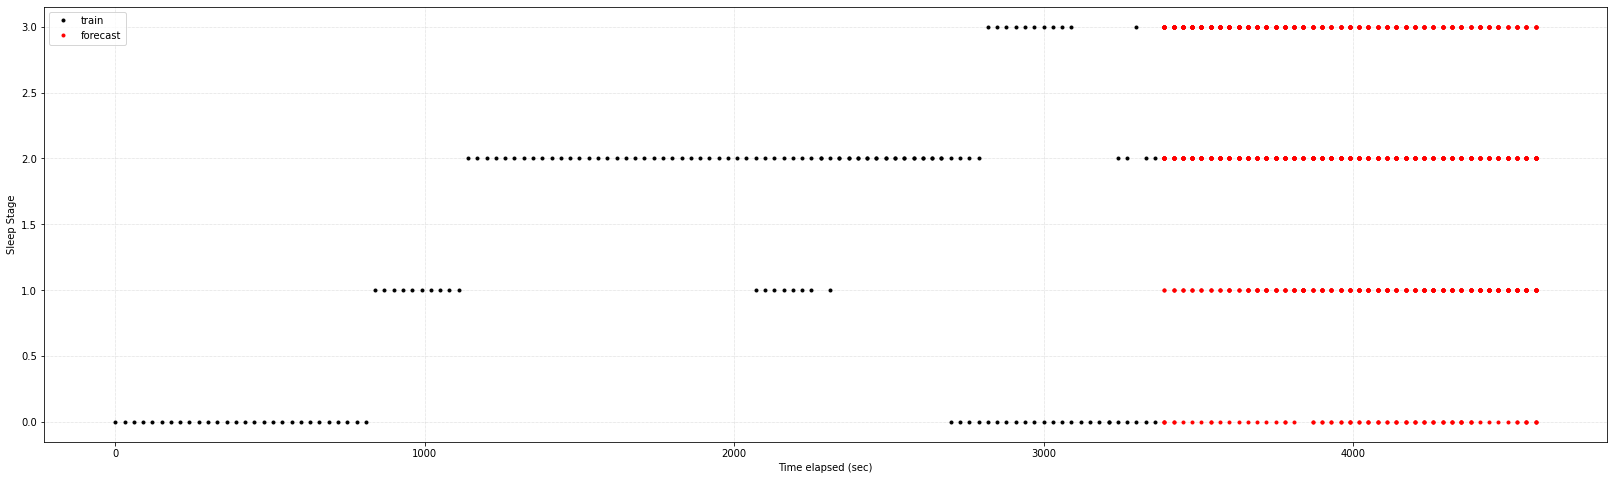

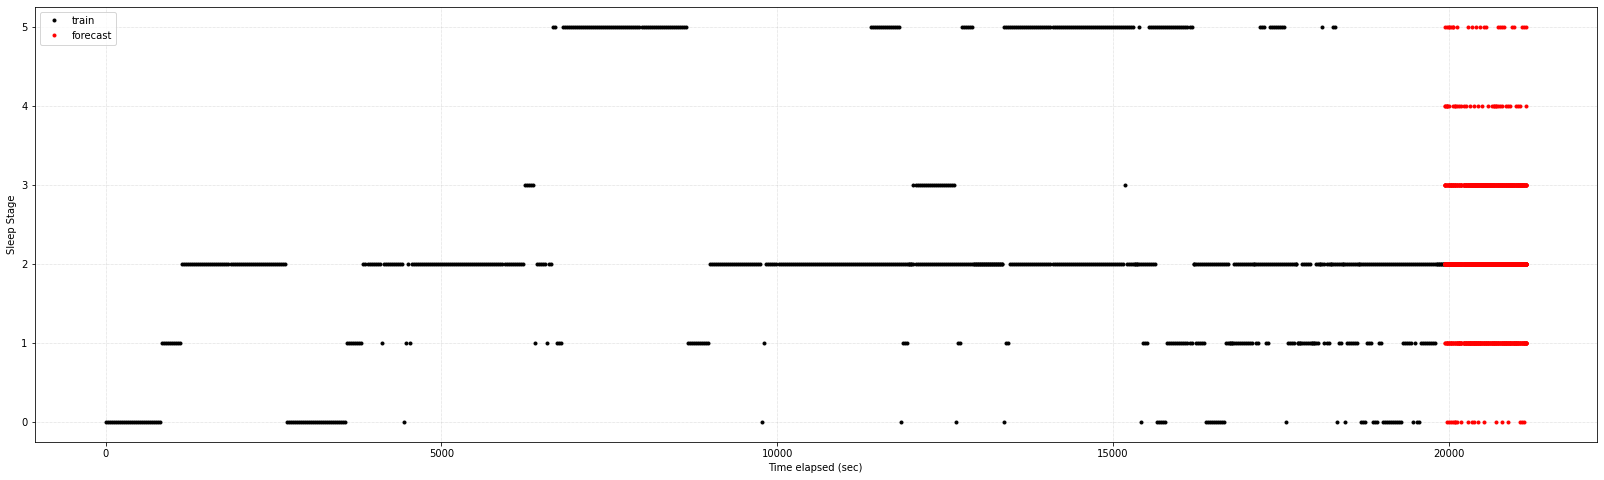

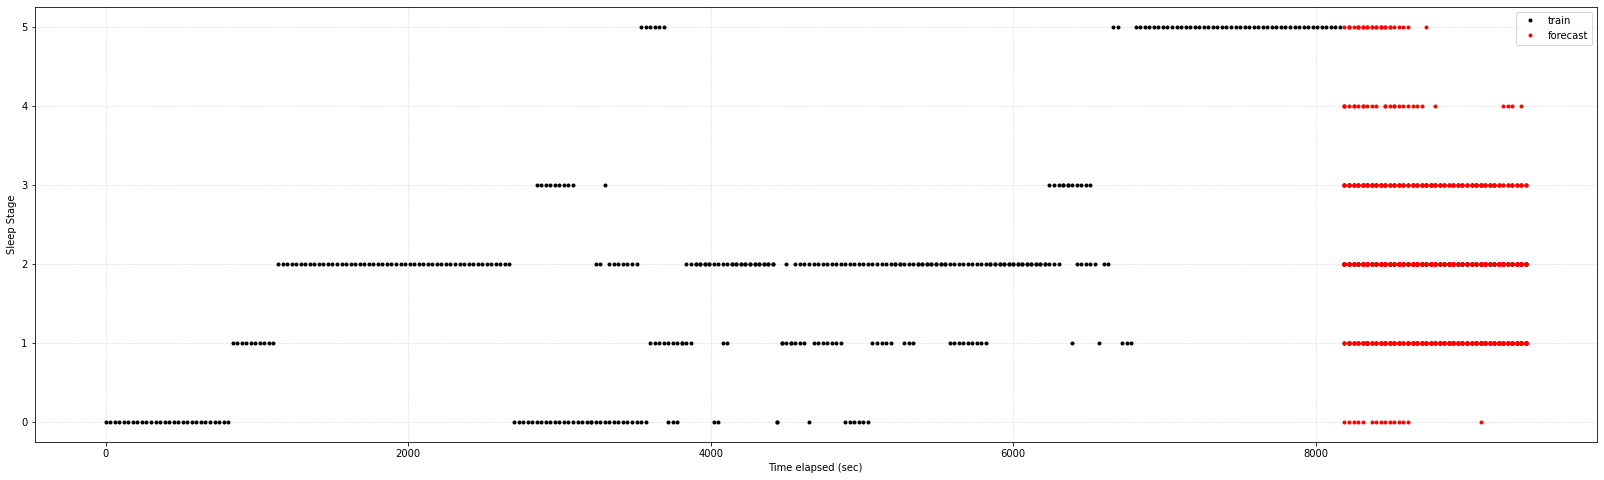

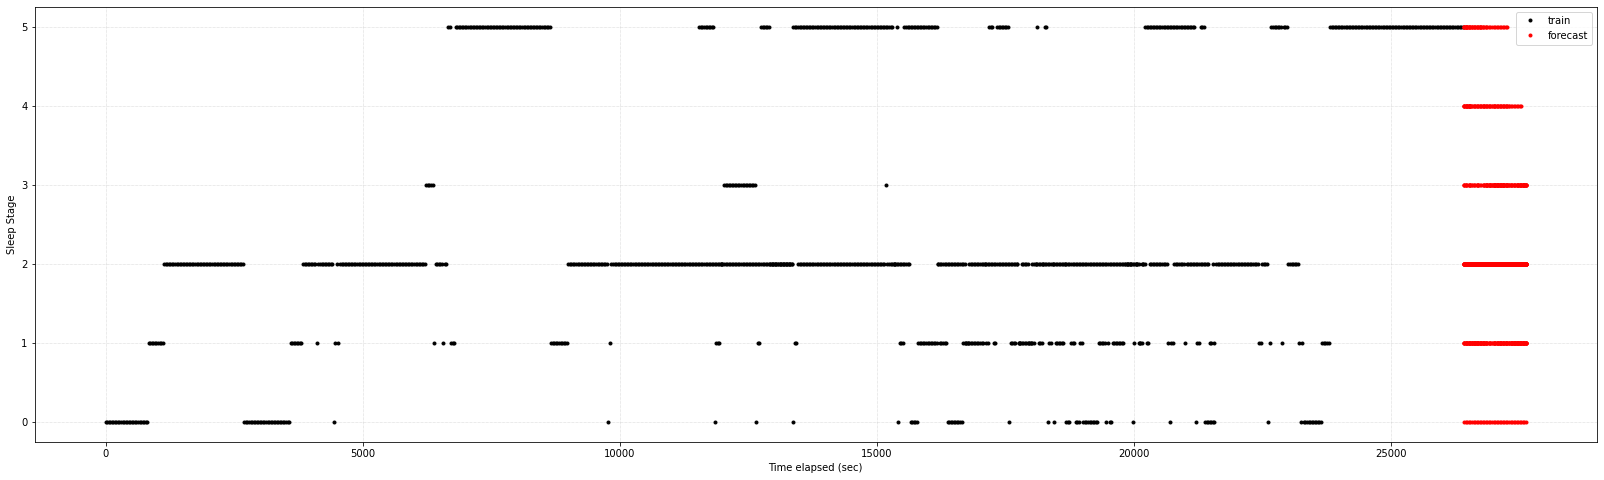

In [ ]:
rf_forecast(df)

## A Better Model - Gradient Boosted Trees

**Gradient boosting** is a type of machine learning boosting. It relies on using ensemble techniques to combine weak classifiers - such as decision trees - into a better model. 

The key idea is to set the target outcomes for this next model in order to minimize the error. The target outcome for each instance depends on what effect changing that instance's prediction affects the end result forecasting error.

In [ ]:
# this function allows us to iteratively train our model
# in steps of 1500, predicting "x" mins ahead

def gradient_boost_forecast(df, minutes_ahead=20, step_rate=1500):
    mean_error = []
    predict_window = minutes_ahead*60

    print("Creating {} models for {} minute prediction windows".format(
        int(round(len(df)*0.2/step_rate)), minutes_ahead
    ))

    for t in range(int(len(df)*0.8), len(df)-minutes_ahead*2, step_rate):
        timestep = df.iloc[t]["time"]

        train = df.loc[df["time"] < timestep].copy()
        val = df.loc[(df['time'] >= timestep) & (df['time'] <= timestep+predict_window)].copy()

        xtr, xts = train.drop(['y'], axis=1), val.drop(['y'], axis=1)
        ytr, yts = train['y'].values, val['y'].values

        mdl = LGBMRegressor(n_estimators=100, learning_rate=0.01)

        mdl.fit(xtr, np.log1p(ytr))

        p = np.expm1(mdl.predict(xts))

        error = rmsle(yts, p)
        print("{} minute prediction error: {}".format(minutes_ahead, error))
        mean_error.append(error)

        plot_predict(train, val, p)

    print('Mean Error = %.5f' % np.mean(mean_error))

As we can see, the error has again been reduced with the use of Gradient Boosted Trees.

Creating 4 models for 20 minute prediction windows
20 minute prediction error: 0.39186439357933867
20 minute prediction error: 0.46211206759956713
20 minute prediction error: 0.3731757404977517
20 minute prediction error: 0.5679151372916458
Mean Error = 0.44877


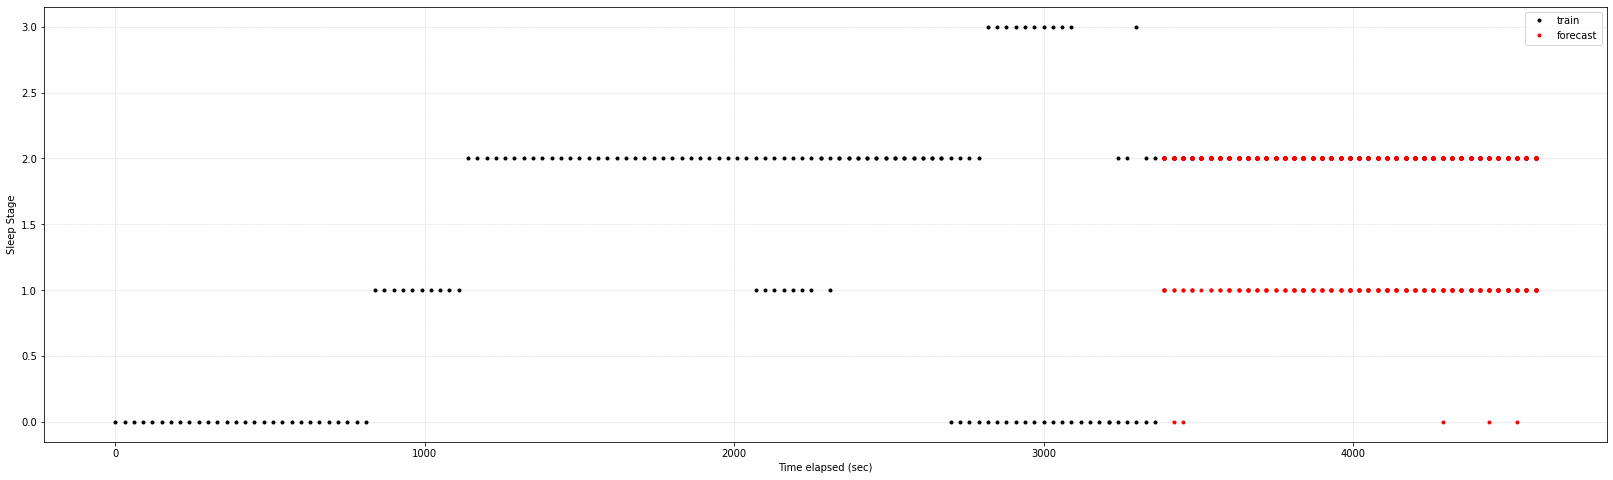

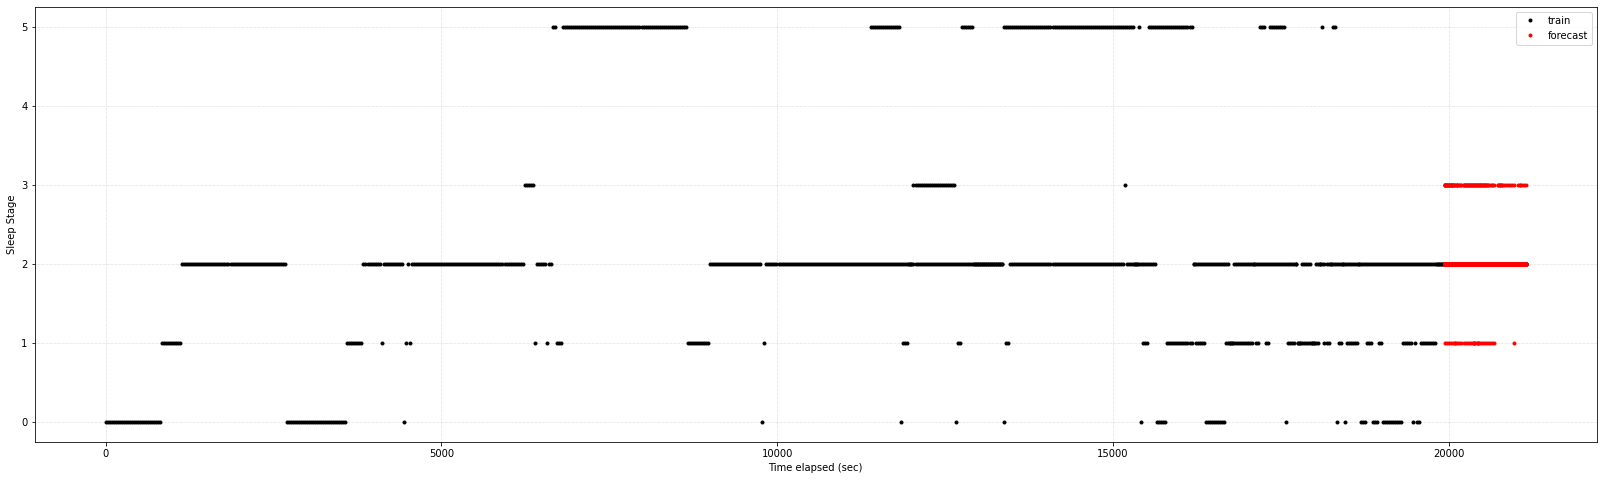

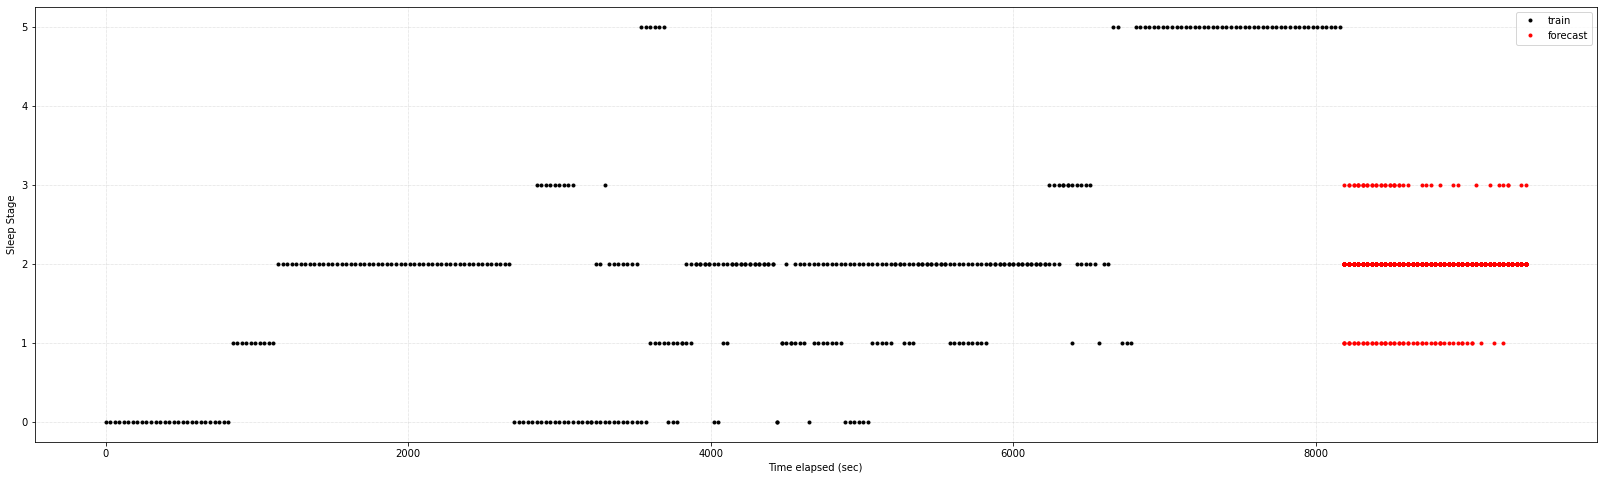

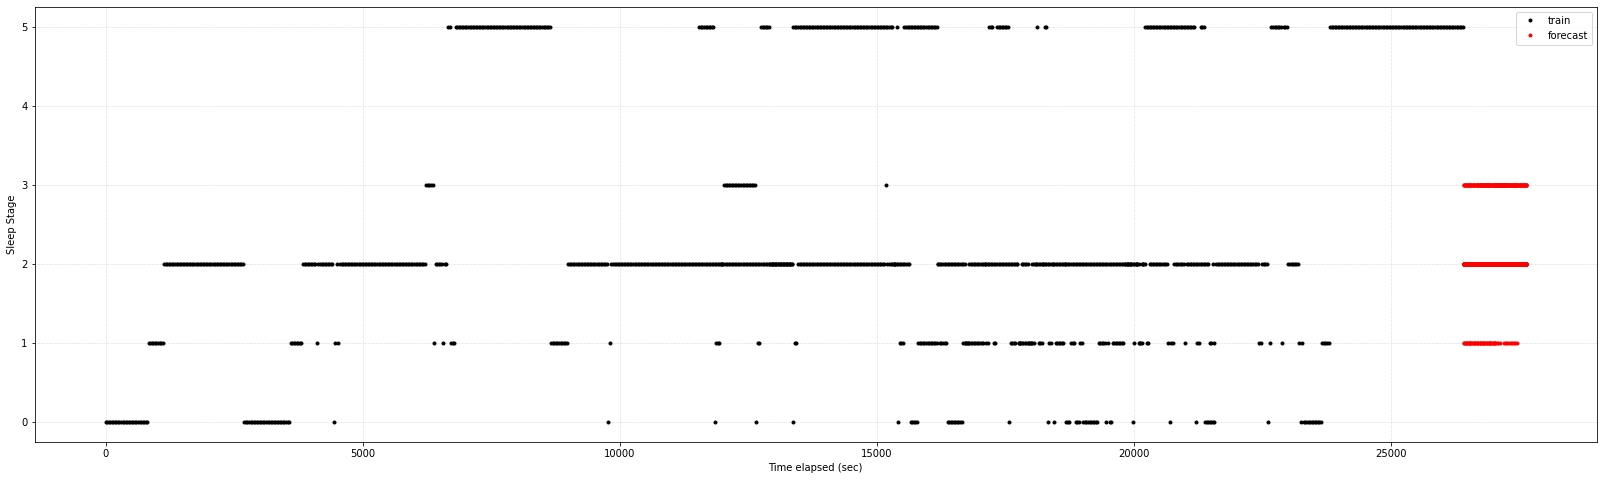

In [ ]:
predictions = gradient_boost_forecast(df)

# Rest of Night Prediction for Individual patients

In previous models, we have been predicting the future sleep stages of all patients. In real world application of this model, we would only expect to be predicting the sleep of one patient - the user. 

Another problem we encountered with trying to predict using the above approach, is that the training data will never show the model that a patient eventually stops sleeping. Therefore, the model will simply predict that each patient sleeps for as long as it is asked to predict. 

To solve this, we will set aside a number of patients as "test" subjects. The rest of the patients will be combined into a "base" as if they were one, with each sleep cycle following after another. 

A model will be created for each subject, using the base training data and a portion of the test subject's sleep data. We will then attempt to predict the rest of the subject's sleep stages for that night.

In [ ]:
# splitting our test subjects up and keeping our large training set

full_set = df.id.unique()
subject_df = {}

base_set = df[df["id"] == full_set[0]]

for i, subj in enumerate(full_set[1:-1]):
    subject_df[subj] = df[df["id"] == subj]
    subject_df[subj]["time"] += (24*60*60*(i+1))  # i days = 86,400sec * i days

    base_set = pd.concat([base_set, subject_df[subj]], axis=0)

for subj in full_set[-1:]:
    subject_df[subj] = df[df["id"] == subj]
    subject_df[subj]["time"] += (24*60*60*(i+2))

#subject_df

This function will build a list of different models for each test subject, making use of Sklearn's TimeSeriesSplit function to facilitate cross validation.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import statistics
import time


def cross_val_forecast(base_set, new_df, label="y", n_splits=5):
    results = []
    names = []

    models = []
    models.append(('Linear Regression', LinearRegression()))
    models.append(('KNN Regressor', KNeighborsRegressor())) 
    models.append(('Random Forest Regressor', RandomForestRegressor(n_estimators = 100)))
    models.append(('Support Vector Regression', SVR(gamma='auto'))) # kernel = linear
    models.append(("Gradient Boosted Trees", LGBMRegressor(n_estimators=100, learning_rate=0.01)))
    # models.append(('NN', MLPRegressor(solver = 'lbfgs', max_iter=10000)))  #neural network
    

    print("Creating {} models for cross validation".format(len(models)))

    start = time.time()
    # loop through each model
    for name, model in models:

        cv_results = []
        tscv = TimeSeriesSplit(n_splits=n_splits)
        print(name, ":")
        
        # loop through each split
        for i, (train_i, val_i) in enumerate(tscv.split(new_df)):
            train = pd.concat([base_set, new_df.copy().iloc[train_i, :]], axis=0)
            val = new_df.copy().iloc[val_i, :]

            print("length of training data: {}".format(len(train)))
            print("length of validation data: {}".format(len(val)))

            xtr, xts = train.drop([label], axis=1), val.drop([label], axis=1)
            ytr, yts = train[label].values, val[label].values

            model.fit(xtr, np.log1p(ytr))

            p = np.expm1(model.predict(xts))

            error = rmsle(yts, abs(p))
            print("Test set prediction error (rmsle): {}\n".format(error))

            cv_results.append(error)

        print("{} Mean error: {}\t95% conf interval: {}".format(name, statistics.mean(cv_results), np.std(cv_results)*2))

        print("Time elapsed {}\n".format(time.time() - start))

        results.append(cv_results)
        names.append(name)


    return results, names


In [ ]:
import pickle
import os

path = "/content/drive/My Drive/CA4015/sleep_classify/subject_results.pkl"

if not os.path.exists(path):

    subject_results = {}

    for sub in full_set[-1:]:
        df = subject_df[sub].copy()
        print("\nCross Validating models for subject {}\n".format(sub))
        results, names = cross_val_forecast(base_set, df)
        subject_results[sub] = [results, names]

    with open(path, 'wb') as handle:
        pickle.dump(subject_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


else:
    with open(path, 'rb') as handle:
        subject_results = pickle.load(handle)


Cross Validating models for subject 9961348

Creating 5 models for cross validation
Linear Regression :
length of training data: 25817
length of validation data: 120
Test set prediction error (rmsle): 0.30529532463421594

length of training data: 25937
length of validation data: 120
Test set prediction error (rmsle): 0.38245215383755626

length of training data: 26057
length of validation data: 120
Test set prediction error (rmsle): 0.3698779457522479

length of training data: 26177
length of validation data: 120
Test set prediction error (rmsle): 0.44820671332337114

length of training data: 26297
length of validation data: 120
Test set prediction error (rmsle): 0.4909741526896178

Linear Regression Mean error: 0.3993612580474018	95% conf interval: 0.1289414884474641
Time elapsed 2.340212821960449

KNN Regressor :
length of training data: 25817
length of validation data: 120
Test set prediction error (rmsle): 1.174837230506229

length of training data: 25937
length of validation data

## Compare Algorithms

We can now compare the performance between different models for each subject. **The lower the score on this graph, the better that model has performed.**

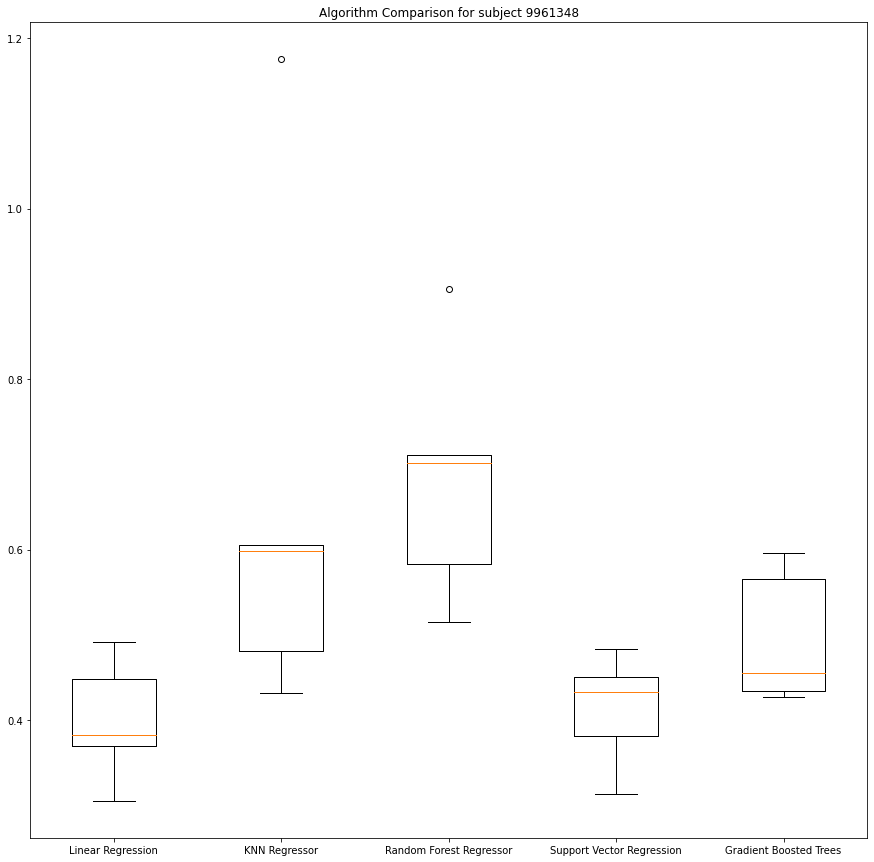

In [ ]:
# Compare Algorithms
for sub in full_set[-1:]:

    results, names = subject_results[sub][0], subject_results[sub][1]
    plt.figure(figsize=(15,15))
    plt.boxplot(results, labels=names)
    plt.title('Algorithm Comparison for subject {}'.format(sub))
    plt.xlabel("Algorithm")
    plt.ylabel("Root Mean Squared Log Error rate")
    plt.show()

## Grid Searching Hyperparameters (nested cross validation)

We would like to take one of our highest performing model - Support Vector Regressor - and use Nested Cross Validation to find the best hyperparamters for it. However, in the interest of time we must choose a model which is faster to train, so we will substitute in Random Forest Regressor here instead.

It is important to leave out a test set at this stage, so we can evaluate this "best" model and ensure it has not overfit to test data.

### Make custom scorer for Root Mean Squared Error (RSME)

In [ ]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):

    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score
    
rmse_score = make_scorer(rmse, greater_is_better = False)

In [ ]:
# find best params for subject

new_df = subject_df[full_set[-1]]
print("Finding best params for subject {}".format(full_set[-1]))

X_full = pd.concat([base_set, new_df.copy()], axis=0)
X_train, X_test = X_full[:int(len(X_full)*0.8)].drop(["y"], axis=1), X_full[int(len(X_full)*0.8):].drop(["y"], axis=1)
y_train, y_test = X_full[:int(len(X_full)*0.8)]["y"].values, X_full[int(len(X_full)*0.8):]["y"].values


from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()

param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
    }

# model = SVR()

# param_search = { 
#     'kernel': ["linear", "poly", "rbf", "sigmoid"],
#     'degree': [2, 5, 10],
#     'gamma': ["scale", "auto"],
#     'C' : [i for i in range(1,5)]
#     }

tscv = TimeSeriesSplit(n_splits=5)

start = time.time()

gsearch = GridSearchCV(estimator=model, cv=tscv,
                       param_grid=param_search, scoring = rmse_score)

gsearch.fit(X_train, y_train)

print("Elapsed time: {} sec".format(time.time() - start))

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

Finding best params for subject 9961348
Elapsed time: 5848.673972129822 sec


## Checking best model performance on test data

In [ ]:
y_pred = best_model.predict(X_test)

regression_results(y_test, y_pred)

explained_variance:  -0.0187
mean_squared_log_error:  0.2538
root_mean_squared_log_error:  0.5038
r2:  -0.0285
MAE:  1.2407
MSE:  2.309
RMSE:  1.5195


# Repeating with Original Features

In our classification task, we found that use of the original windowed features provided classifiers that performed almost as well as models trained on extracted features. We will do the same here, and examine the performance of forecasting models using the original features.

In [ ]:
# load the dataset
X = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/raw_windowed_features.csv')
Y = pd.read_csv('/content/drive/My Drive/CA4015/sleep_classify/raw_windowed_labels.csv')
# summarize shape
print(X.shape)
print(Y.shape)
# show first few rows
print(X.head())
print(Y.head())

(26417, 6)
(26417, 3)
   Unnamed: 0         x         y         z    hr       id
0       870.0 -0.612717 -0.086441 -0.774131  74.5  8692923
1       900.0 -0.608009 -0.078117 -0.779465  66.5  8692923
2       930.0 -0.608291 -0.074685 -0.776802  68.0  8692923
3       960.0 -0.604043 -0.074944 -0.782837  71.0  8692923
4       990.0 -0.607269 -0.070290 -0.782433  68.0  8692923
     0  1       id
0  870  0  8692923
1  900  0  8692923
2  930  0  8692923
3  960  0  8692923
4  990  0  8692923


In [ ]:
# SORT AND RE LABEL DF 

df = pd.concat([Y, X[X.columns[1:-1]]], axis=1)
df = df.rename(columns={"1": "label", "0": "time"})
df = df.sort_values(["id", "time"])
df = df.reset_index(drop=True)
df = df.dropna()
df

,time,label,id,x,y,z,hr
0,390,0,46343,-0.559524,0.690460,-0.220322,90.0
1,420,0,46343,-0.631027,0.672783,-0.314141,101.0
2,450,0,46343,-0.115540,0.853890,0.774827,92.0
3,480,0,46343,-0.345749,-0.284614,0.888367,82.0
4,510,0,46343,-0.315613,-0.276604,0.906998,83.0
...,...,...,...,...,...,...,...
26412,21450,0,9961348,-0.389702,-0.006797,-0.913902,71.0
26413,21480,0,9961348,-0.259171,0.257347,-0.925720,73.5
26414,21510,0,9961348,-0.263367,0.256363,-0.924820,67.0
26415,21540,0,9961348,-0.265327,0.258561,-0.927559,68.0


In [ ]:
# splitting our test subjects up and keeping our large training set

full_set = df.id.unique()
subject_df = {}

base_set = df[df["id"] == full_set[0]]

for i, subj in enumerate(full_set[1:-3]):
    subject_df[subj] = df[df["id"] == subj]
    subject_df[subj]["time"] += (24*60*60*(i+1))  # i days = 86,400sec * i days

    base_set = pd.concat([base_set, subject_df[subj]], axis=0)

for subj in full_set[-3:]:
    subject_df[subj] = df[df["id"] == subj]
    subject_df[subj]["time"] += (24*60*60*(i+2))

In [ ]:
import pickle
import os

path = "/content/drive/My Drive/CA4015/sleep_classify/raw_subject_results.pkl"

if not os.path.exists(path):

    subject_results = {}

    for sub in full_set[-3:]:

        df = subject_df[sub].copy()
        print("\nCross Validating models for subject {}\n".format(sub))
        results, names = cross_val_forecast(base_set, df, label="label")
        subject_results[sub] = [results, names]

    with open(path, 'wb') as handle:
        pickle.dump(subject_results, handle, protocol=pickle.HIGHEST_PROTOCOL)


else:
    with open(path, 'rb') as handle:
        subject_results = pickle.load(handle)


Cross Validating models for subject 9106476

Creating 5 models for cross validation
Linear Regression :
length of training data: 24035
length of validation data: 160
Test set prediction error (rmsle): 0.2986088784240038

length of training data: 24195
length of validation data: 160
Test set prediction error (rmsle): 0.3470357173578335

length of training data: 24355
length of validation data: 160
Test set prediction error (rmsle): 0.14312694528559142

length of training data: 24515
length of validation data: 160
Test set prediction error (rmsle): 0.323786476610393

length of training data: 24675
length of validation data: 160
Test set prediction error (rmsle): 0.8271836434229798

Linear Regression Mean error: 0.3879483322201603	95% conf interval: 0.4618547770741456
Time elapsed 0.07478499412536621

KNN Regressor :
length of training data: 24035
length of validation data: 160
Test set prediction error (rmsle): 0.28763669910372064

length of training data: 24195
length of validation dat

We can see that the beginning and end portions of sleep cycles are again particularly difficult to predict for all algorithms. 

Below we can plot each model's performance for each subject to compare which may be suitable for further examinaton.

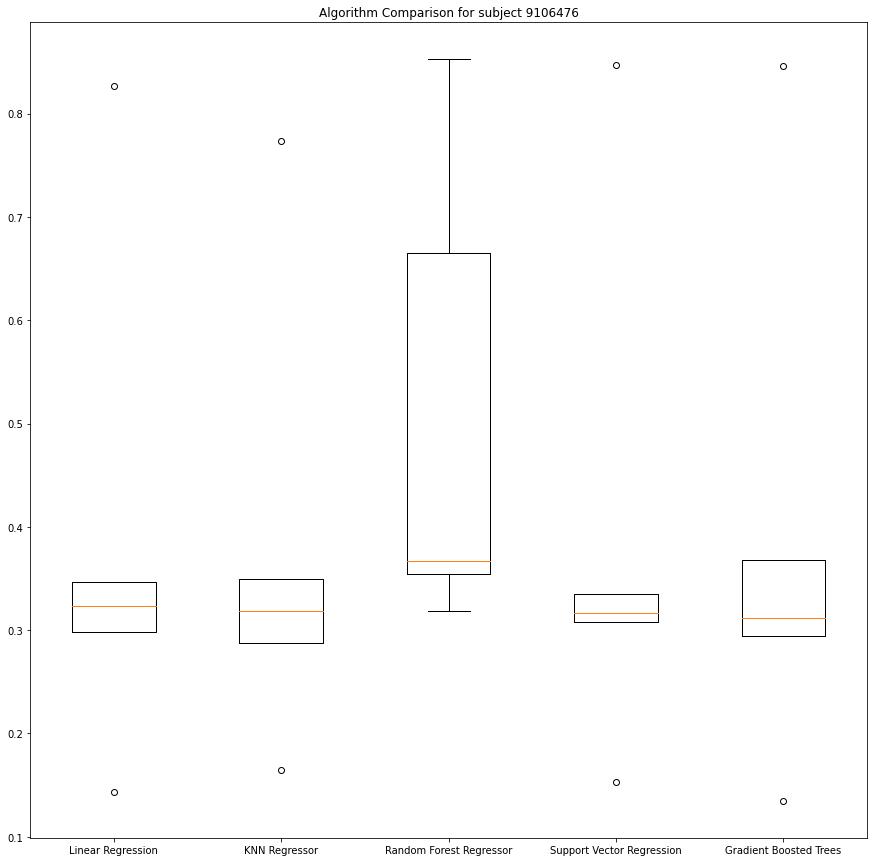

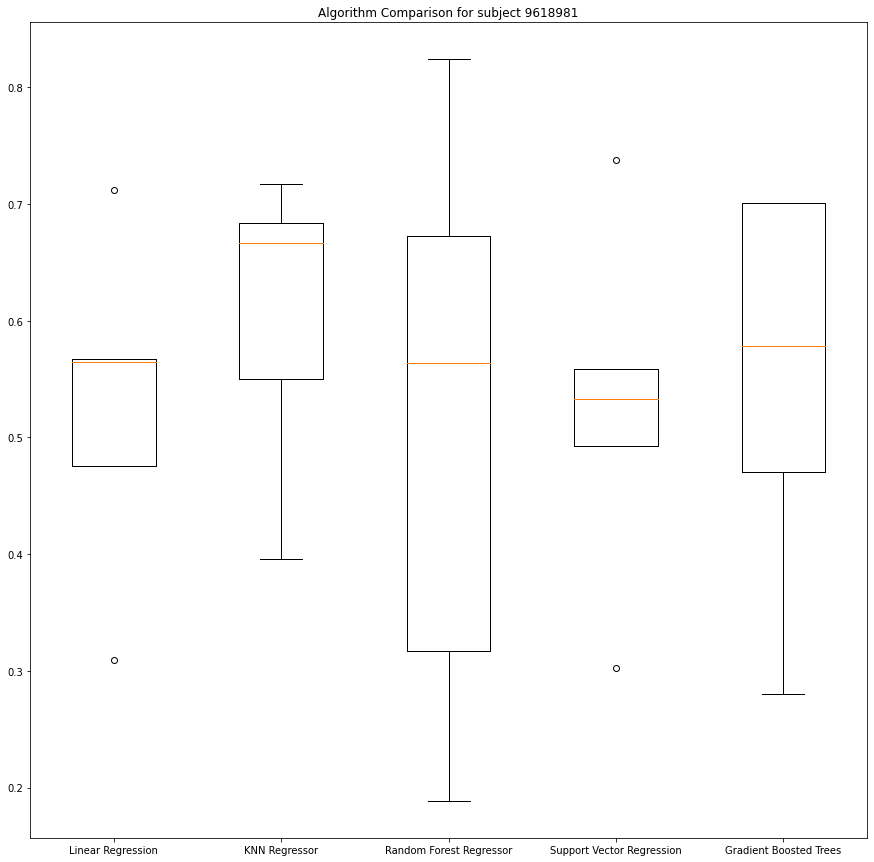

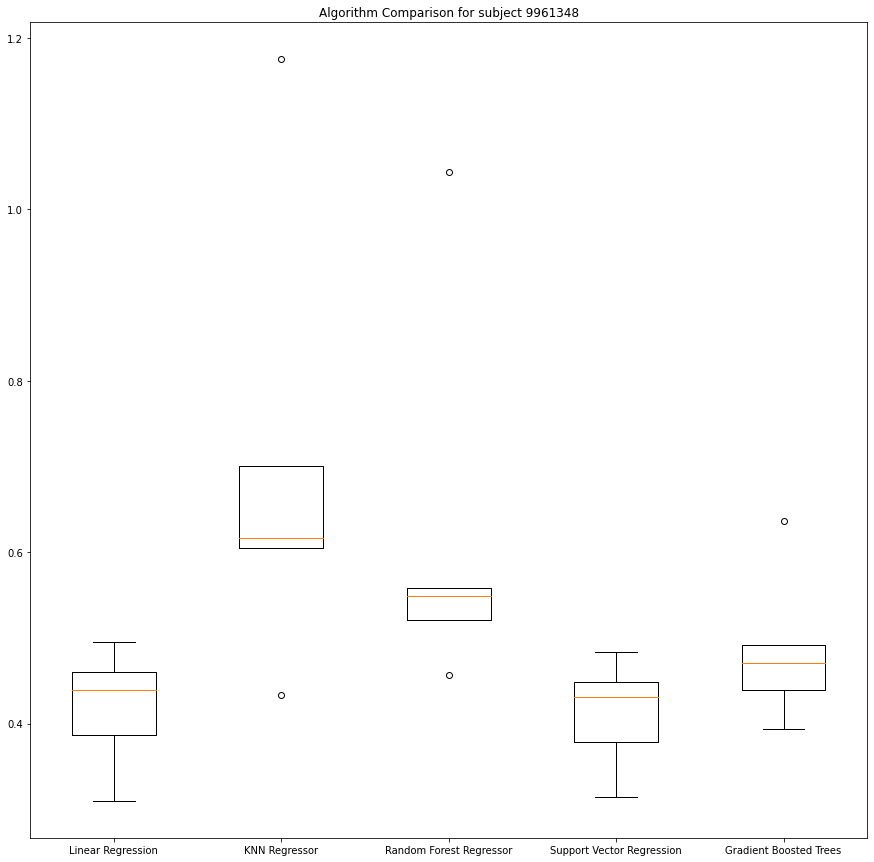

In [ ]:
# Compare Algorithms
for sub in full_set[-3:]:

    results, names = subject_results[sub][0], subject_results[sub][1]
    plt.figure(figsize=(15,15))
    plt.boxplot(results, labels=names)
    plt.title('Algorithm Comparison for subject {}'.format(sub))
    plt.xlabel("Algorithm")
    plt.ylabel("Root Mean Squared Log Error rate")
    plt.show()

## Grid Searching Hyperparameters (nested cross validation)

We will take one of our reasonably well-performing Gradient Boosted Trees - as shown above - and use Nested Cross Validation to find the best hyperparamters, with regards to the final test subject. However, in the interest pf time we must choose a model which is faster to train, so we will substitute in K Neighbors Regressor here instead.

In [ ]:
# find best params for subject

new_df = subject_df[full_set[-1]]
print("Finding best params for subject {}".format(full_set[-1]))

X_full = pd.concat([base_set, new_df.copy()], axis=0)
X_train, X_test = X_full[:int(len(X_full)*0.8)].drop(["label"], axis=1), X_full[int(len(X_full)*0.8):].drop(["label"], axis=1)
y_train, y_test = X_full[:int(len(X_full)*0.8)]["label"].values, X_full[int(len(X_full)*0.8):]["label"].values


from sklearn.model_selection import GridSearchCV

model = KNeighborsRegressor()

param_search = { 
    'n_neighbors': [2, 5, 10],
    'algorithm': ['auto', 'ball_tree', 'brute'],
    'p' : [1, 2, 4]
    }


# model = LGBMRegressor()

# param_search = { 
#     'boosting_type': ["gbdt", "dart", "goss", "rf"],
#     'n_estimators': [20, 50, 100],
#     'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.6],
#     'max_depth' : [i for i in range(0,10)]
#     }

tscv = TimeSeriesSplit(n_splits=5)

start = time.time()

gsearch = GridSearchCV(estimator=model, cv=tscv,
                       param_grid=param_search, scoring = rmse_score)

gsearch.fit(X_train, y_train)

print("Elapsed time: {} sec".format(time.time() - start))

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

Finding best params for subject 9961348
Elapsed time: 276.8463439941406 sec


## Checking best model performance on test data

In [ ]:
y_pred = best_model.predict(X_test)

regression_results(y_test, y_pred)

explained_variance:  0.0
mean_squared_log_error:  0.2421
root_mean_squared_log_error:  0.4921
r2:  -0.1693
MAE:  1.1061
MSE:  2.7845
RMSE:  1.6687


# Conclusion

We see that models trained using the extracted features dataset generally perform better than those trained on the original features. However, both approaches struggle with forecasting the beginning and end of a sleep cycle. This may be due to the fact that we have concatenated different people's sleep data together, all with different charactersitics that the model has difficulty consolidating into a recognisable pattern.

It is also interesting to note that different models work better for different subjects. Future work could be done in this area, whereby multiple nights' sleep are recorded per subject, and a comparison of each model could be carried out to identify a significantly superior algorithm.

